## Install deps

In [1]:
!pip install pandas numpy requests matplotlib
!pip install tf-agents
!pip install tf-keras

  Using cached typing_extensions-4.5.0-py3-none-any.whl.metadata (8.5 kB)
Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 8.25.0 requires typing-extensions>=4.6; python_version < "3.12", but you have typing-extensions 4.5.0 which is incompatible.


In [2]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

### Download the dataset from my netlify deployment. As Collab is ephemeral
And I am lazy to spin up new nginx on my traefik host at home

In [3]:
import requests
base_url = "https://dc-bandits-ab-06e963.netlify.app/dataset-"
files = ["zakladni.csv","discovery.csv","segment.csv"]

for file in files:
  response = requests.get(base_url+file, stream=True)
  with open(file,'wb') as output:
    output.write(response.content)

## Data preparation
Aggregate the data by 30 minutes intervals

In [4]:
import pandas as pd
import numpy as np

data = pd.DataFrame()
for file in files:
  variant = pd.read_csv(file)
  variant['minute'] = pd.to_datetime(variant['minute'])
  variant.set_index('minute', inplace=True)
  variant = variant.resample('2H').agg({'visits':'sum', 'clicks':'sum'}).dropna()

  variant.index.rename("interval", inplace=True)
  variant['variant'] = file.replace(".csv", "")
  print(len(variant))
  data = pd.concat([data, variant])

print(data.head())
print(data.tail())

215
215
215
                     visits  clicks   variant
interval                                     
2023-03-06 16:00:00     283       1  zakladni
2023-03-06 18:00:00     373       7  zakladni
2023-03-06 20:00:00     276       3  zakladni
2023-03-06 22:00:00     136       5  zakladni
2023-03-07 00:00:00      71       3  zakladni
                     visits  clicks  variant
interval                                    
2023-03-24 04:00:00      79       1  segment
2023-03-24 06:00:00     173       3  segment
2023-03-24 08:00:00     299       6  segment
2023-03-24 10:00:00     403      11  segment
2023-03-24 12:00:00     245      14  segment


/tmp/ipykernel_6868/1509006101.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  variant = variant.resample('2H').agg({'visits':'sum', 'clicks':'sum'}).dropna()
/tmp/ipykernel_6868/1509006101.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  variant = variant.resample('2H').agg({'visits':'sum', 'clicks':'sum'}).dropna()
/tmp/ipykernel_6868/1509006101.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  variant = variant.resample('2H').agg({'visits':'sum', 'clicks':'sum'}).dropna()


## Prepare Tensorflow Bandit Agents

In [5]:
import tensorflow as tf

from tf_agents.bandits.environments.bandit_py_environment import BanditPyEnvironment
from tf_agents.specs import array_spec


class ABCTestBanditEnv(BanditPyEnvironment):
    def __init__(self, data):
        self.data = data
        self.current = 0

        # Num of A/B variants (actions)
        self.variants = data['variant'].unique()
        action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=len(self.variants) - 1, name='action')

        # Define observation as a vector of the day of the week (0-6) and hour of the day (0-23)
        observation_spec = array_spec.ArraySpec(
            shape=(2,), dtype=np.int32, name='observation')

        super(ABCTestBanditEnv, self).__init__(observation_spec, action_spec)

        # Precompute CTR for each variant
        self.data['CTR'] = self.data['clicks'] / self.data['visits']

        # Normalize day and hour for observations
        self.data['day_of_week'] = self.data.index.dayofweek
        self.data['hour_of_day'] = self.data.index.hour

    def _observe(self):
        if self.current >= len(self.data):
            self.current = 0  # reset to loop through the data
        # Construct the observation from the current interval
        obs_data = self.data.iloc[self.current]
        self._observation = np.array([obs_data['day_of_week'], obs_data['hour_of_day']], dtype='int32')
        return self._observation

    def _apply_action(self, action):
        # Get the current time interval data
        obs_data = self.data.iloc[self.current]
        current_time = obs_data.name

        current_interval_data = self.data.loc[current_time]
        total_visits = current_interval_data['visits'].sum()

        # Allocate traffic based on action taken
        chosen_variant = self.variants[action]
        chosen_variant_data = current_interval_data[current_interval_data['variant'] == chosen_variant]

        # Calculate the new visits and clicks based on the chosen variant's CTR
        new_clicks = total_visits * chosen_variant_data['CTR'].values[0]

        # Calculate reward as the CTR
        reward = new_clicks / total_visits if total_visits > 0 else 0
        print(reward)
        self.current += 1
        return reward




2024-06-14 18:07:15.708165: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-14 18:07:15.708785: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-14 18:07:15.711070: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-14 18:07:15.737077: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 18:07:16.179195: W tensorflow/compiler/tf2tensorrt/utils/py_uti

In [6]:
from tf_agents.environments import tf_py_environment
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory

# Create the environment
env = ABCTestBanditEnv(data)
env = tf_py_environment.TFPyEnvironment(env)

# Define time_step_spec and action_spec
time_step_spec = env.time_step_spec()
action_spec = env.action_spec()

# Initialize the agent
agent = lin_ucb_agent.LinearUCBAgent(
    time_step_spec=time_step_spec,
    action_spec=action_spec,
    alpha=0.5,  # Adjust exploration level
    tikhonov_weight=1.0,  # Regularization to prevent overfitting
    dtype=tf.float32
)

# Setup Replay Buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=env.batch_size,
    max_length=1000)

actions_taken = []

# Function to collect data from interactions
def collect_step(env, policy):
    time_step = env.current_time_step()
    action_step = policy.action(time_step)
    # Log
    actions_taken.append(action_step.action.numpy())
    next_time_step = env.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)

# Training Loop
num_iterations = 1000 # Number of iterations for training
for _ in range(num_iterations):
    # Collect data from the environment
    collect_step(env, agent.policy)

    # Sample a batch of data from the buffer and update the agent's network
    experience = replay_buffer.gather_all()
    train_loss = agent.train(experience)
    replay_buffer.clear()

    print(f"Step: {_}, Loss: {train_loss.loss.numpy()}")

print("Training completed.")

0.0035335689045936395
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.
Step: 0, Loss: 1.2486108971643262e-05
0.034210526315789476
Step: 1, Loss: 0.001170360017567873
0.015723270440251572
Step: 2, Loss: 0.00024722126545384526
0.03676470588235294
Step: 3, Loss: 0.0010192027548328042
0.042253521126760556
Step: 4, Loss: 0.0017853599274531007
0.08333333333333333
Step: 5, Loss: 0.006327225361019373
0.046511627906976744
Step: 6, Loss: 0.0018813745118677616
0.04861111111111111
Step: 7, Loss: 1.4028770237928256e-05
0.01929260450160772
Step: 8, Loss: 0.00012492098903749138
0.014388489208633094
Step: 9, Loss: 0.00028350844513624907
0.03571428571428571
Step: 10, Loss: 0.0007774344994686544
0.0030303030303030303
Step: 11, Loss: 0.002862703986465931
0.010554089709762533
Step: 12, Loss: 0.00035286095226183534
0.0226628895184136
Step: 13, Loss: 0.00021294796897564083
0.027700831024930747
Step: 14, Loss: 0.00029404647648334503
0.00847457627118644
Step: 15, Loss:

      zakladni  discovery  segment
step                              
999       31.4       30.5     38.1


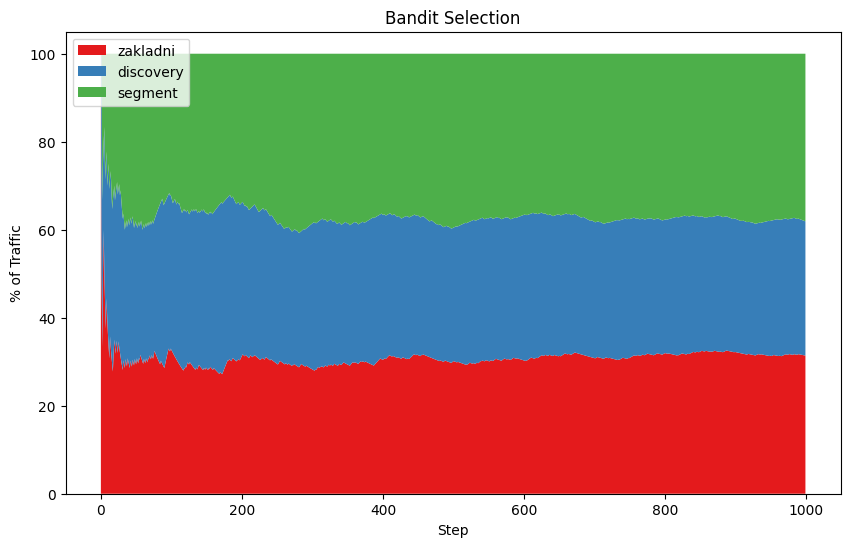

In [7]:
import matplotlib.pyplot as plt

actions_df = pd.DataFrame(actions_taken, columns=['action'])
actions_df['step'] = actions_df.index

# Count the occurrences of each action at each step
actions_count_df = actions_df.groupby(['step', 'action']).size().unstack(fill_value=0)

# Calculate the cumulative sum to get the traffic over time
cumulative_counts = actions_count_df.cumsum()

# Calculate the percentage of traffic allocated to each variant
cumulative_percents = cumulative_counts.div(cumulative_counts.sum(axis=1), axis=0) * 100

cumulative_percents.columns = data['variant'].unique()
print(cumulative_percents.tail(1), )
# Plotting the area chart
plt.figure(figsize=(10, 6))
plt.stackplot(cumulative_percents.index, cumulative_percents.T, labels=cumulative_percents.columns, colors=['#e41a1c', '#377eb8', '#4daf4a'])
plt.legend(loc='upper left')
plt.xlabel('Step')
plt.ylabel('% of Traffic')
plt.title('Bandit Selection')
plt.show()

In [ ]:
def simulate_clicks(row):
    visits = int(row['visits'])
    clicks = int(row['clicks'])
    if visits == 0:
        probability
    else:
        probability = clicks / visits
    # Bernoulliho schéma
    clicks = np.random.binomial(1, probability, visits)
    return clicks

Add rewards simulation